<a href="https://colab.research.google.com/github/mivantec/Ivantechenko_BIX_F21/blob/main/MI_Homework5_Curiosity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Curiosity" Homework



## Section A - "Choose your fighter"

In this homework, we will be exploring (pun intended) some more agents for the multi-armed bandit task. This assignment will also be a bit more open-ended. Up until now, we have always specified which agents to run, but now you will be tasked with "designing" your own agents. Not from scratch of course, but from the set of building blocks (Actors and Critics) which we established in Lab 4 and Lab 5.

So far we have seen 5 different Actors, which use the estimated values for the different arms to return a selection according to different strategies.

- DeterministicActor (out)
- BoundedRandomActor (parameterized by bound)
- BoundedSequentialActor (parameterized by bound)
- EpsilonActor (parameterized by epsilon)
- SoftmaxActor (parameterized by beta)

We have also seen 3 different Critics, which are responsible for returning the "value" of each arm by combining extrinsic and (possibly) intrinsic values.

- Critic (out)
- CriticUCB
- CriticNovelty

If you do the math, there's 15 possible combinations. Between labs 4 and 5, we have used 7:

- DeterministicActor / Critic
- BoundedRandomActor / Critic
- BoundedSequentialActor / Critic
- EpsilonActor / Critic
- SoftmaxActor / Critic
- DeterministicActor / CriticUCB
- DeterministicActor / CriticNovelty

Our main question: which combinations of Actor and Critic work best?

To help answer this question, we will ask you to select three new combinations to test out. You will be asked to tune your selected agents and run them in different evironments.

### Question 1 [5 pts]

Create a list of three *new* Actor/Critic pairings, which will serve as your agents for the remainder of this assignment.

There's a second restriction we are adding: you can't use the same critic for all three agents.

BoundedRandomActor/CriticUCB

BoundedSequentialActor/CriticNovelty

EpsilonActor/CriticUCB

## Section B - Notebook setup [5 pts]

This lab uses the `DeceptiveBanditOneHigh10` environment (along with the `DeceptiveBanditEnv` parent class), which have been newly ported to explorationlib.  Therefore, you will have to update your personal copy of `local_gym.py` to include these two classes (which can be found in the clappm/explorationlib repo).

Install explorationlib, import the agents/critics/environments, and configure the notebook

In [3]:
# Install
!pip install --upgrade git+https://github.com/mivantec/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

  Cloning https://github.com/mivantec/explorationlib to /tmp/pip-req-build-pbi95ol1
  Running command git clone -q https://github.com/mivantec/explorationlib /tmp/pip-req-build-pbi95ol1
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=25304 sha256=c9d8269852912485af6ccbee4f5b41d86a79fd669bef453b6ba6d0520d9217bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-w11p_iqm/wheels/ba/ac/15/11cb741980bda3079e70fd27f4f2332443ddbda1bad98ffb8d
Successfully built explorationlib
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-jhpvt85r
  Running command git clone -q https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-jhpvt85r
     |████████████████████████████████| 18.3 MB 108 kB/s 
  Created wheel for gym-maze: filename=gym_maze-0.4-py3-none-any.whl size=14241 sha256=57e683f3a2e3cdd575a5426c8850ceb1897a75ad4e2a98c3bf1af2fac262e62a
  Stored in directory: /tmp/pip-ephem-wheel-cache-gq6top90/wheels/01/f8/86/0dd8c448e192abff0

In [4]:
# import basic modules
import shutil
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import explorationlib
import explorationlib

# import the type of environment we will be using
from explorationlib.local_gym import BanditUniform4
from explorationlib.local_gym import BanditUniform10
from explorationlib.local_gym import DeceptiveBanditOneHigh10

# import the components to build our agents
from explorationlib.agent import BanditActorCritic
from explorationlib.agent import BoundedRandomActor
from explorationlib.agent import BoundedSequentialActor

from explorationlib.agent import EpsilonActor
from explorationlib.agent import CriticUCB
from explorationlib.agent import CriticNovelty

# import the experimental framework
from explorationlib.run import experiment

# import some scoring functions
from explorationlib.score import total_reward
from explorationlib.score import action_entropy

# import some utility functions
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# import some plotting functions
from explorationlib.plot import plot_bandit
from explorationlib.plot import plot_bandit_actions
from explorationlib.plot import plot_bandit_critic
from explorationlib.plot import plot_bandit_hist

pygame 2.1.0 (SDL 2.0.16, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Section C - Four-arm bandits [40 pts total]



We will first consider the 4-arm environment we've used several times before.

### Creating the training environment

It's always good practice to test your agents on a different environment than the one on which they were trained.  For now we will create a training environment.

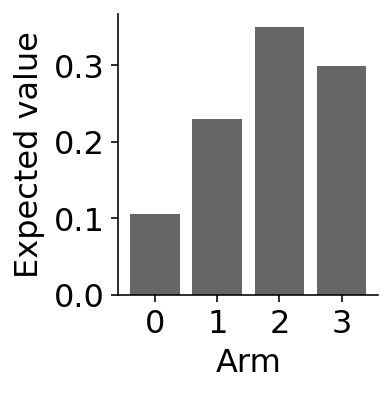

In [6]:
# don't touch
# Shared env params
seed = 412
num_steps = 400

# Create env
env = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.35)
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

### Question 2 [15 pts]

How do you expect your agents to perform relative to each other, in a 4-arm environment after they have been tuned? Which one will do best and which one will do worst?  Please explain your ranking, *considering the functionality and contributions of both the Actor and Critic components of each agent*. To help justify your hypothesis, it will be useful to briefly reference previous simulations and results (Labs 4/5 and HW 4).

Ranking: Epsilon/CriticUCB > BoundedRandom/CriticUCB > BoundedSequential/CriticNovelty

Lab 5 compared between DeterministicActor with either CriticUCB or CriticNovelty and found that a lot more total reward with CriticNovelty than CriticUCB (90 vs. 135) for 4-armed bandit. Because of this, I would intially predict that any agent with CriticNovelty would outperform any agent with CriticUCB. However, I think the type of agent changes this. I predict that Epsilon will perform the best even though it has CriticUCB and not CriticNovelty. Both bounded agents are just pure exploratory agents that occasionally get lucky. On the other hand, Epsilon is a Q learning agent that is choosing its actions based on the estimated Q values/learning from the environment. In Lab 4 and HW 4 which compared between BoundedRandom and BoundeSequential, we see that both performed similiarly, though BoundedRandom tended to perform better than BoundedSequential. In both cases, since the actor is not learning from the Q values provided by the critic, I will use the performance of each actor when critic is held constant as justification, so I predict that BoundedRandom will outperform BoundedSequential in this case. 


### Tuning Agent 1 for 4-armed bandit [5 pts]

Each of your agents should have 1 tunable parameter.  The name and functionality of this parameter depends on which Actors you selected. For this homework, we are not going to be tuning the Critic in any way, we will simply be using the default parameters. The examples from Lab 5 should show you how to create an agent from a combination of Actor and Critic.

First tune the parameter of Agent 1, whatever it may be, using the training environment we've established. Show your different simulation batches and plots in different cells so that we may see your work.  The exact process by which you tune your agents is up to you.

We understand that tuning can be tedious... we are not asking for perfection. We don't have an answer key for parameter values. The goal is just for you to find parameters that are *good enough* so that the comparison between agents can be considered fair.

In [ ]:
# Agent 1 = BoundedRandomActor/CriticUCB, tunable parameter = bound

In [9]:
num_steps = 4 * 100
num_experiments = 250

b_4:   0%|          | 0/250 [00:00<?, ?it/s]

b_48:   0%|          | 0/250 [00:00<?, ?it/s]

b_92:   0%|          | 0/250 [00:00<?, ?it/s]

b_136:   0%|          | 0/250 [00:00<?, ?it/s]

b_180:   0%|          | 0/250 [00:00<?, ?it/s]

b_224:   0%|          | 0/250 [00:00<?, ?it/s]

b_268:   0%|          | 0/250 [00:00<?, ?it/s]

b_312:   0%|          | 0/250 [00:00<?, ?it/s]

b_356:   0%|          | 0/250 [00:00<?, ?it/s]

b_400:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

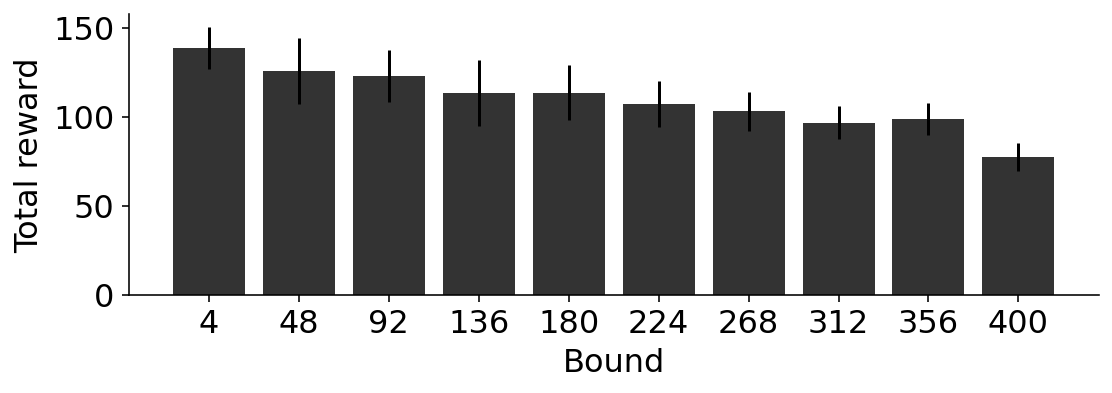

In [10]:
# CHANGE ME
start = 4 # min 4
stop = num_steps # max num_steps
num_search = 10 # ?

# -
# LEAVE ME
bounds = np.linspace(start, stop, num_search).astype(int)
names = [str(np.round(bound, 2)) for bound in bounds]

# !
results = []
for i, (name, bound) in enumerate(zip(names, bounds)):
    agent = BanditActorCritic(
        BoundedRandomActor(num_actions=env.num_arms, bound=bound),
        CriticUCB(num_inputs=env.num_arms, default_value=0.0)
    )
    log = experiment(
        f"b_{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

# Score
scores = []
for name, res in zip(names, results):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s) in zip(names, scores):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot
fig = plt.figure(figsize=(8, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Bound")
plt.tight_layout()
sns.despine()

What parameter value did you you settle on for Agent 1?

I decided on a bound of 26. A bound of 4 returns the highest total reward, while 48 returns the second highest, so I just took the average of the two.

### Tuning Agent 2 for 4-armed bandit [5 pts]

In [ ]:
# Agent 2 = BoundedSequentialActor/NoveltyCritic, tunable parameter = bound

b_4:   0%|          | 0/250 [00:00<?, ?it/s]

b_48:   0%|          | 0/250 [00:00<?, ?it/s]

b_92:   0%|          | 0/250 [00:00<?, ?it/s]

b_136:   0%|          | 0/250 [00:00<?, ?it/s]

b_180:   0%|          | 0/250 [00:00<?, ?it/s]

b_224:   0%|          | 0/250 [00:00<?, ?it/s]

b_268:   0%|          | 0/250 [00:00<?, ?it/s]

b_312:   0%|          | 0/250 [00:00<?, ?it/s]

b_356:   0%|          | 0/250 [00:00<?, ?it/s]

b_400:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

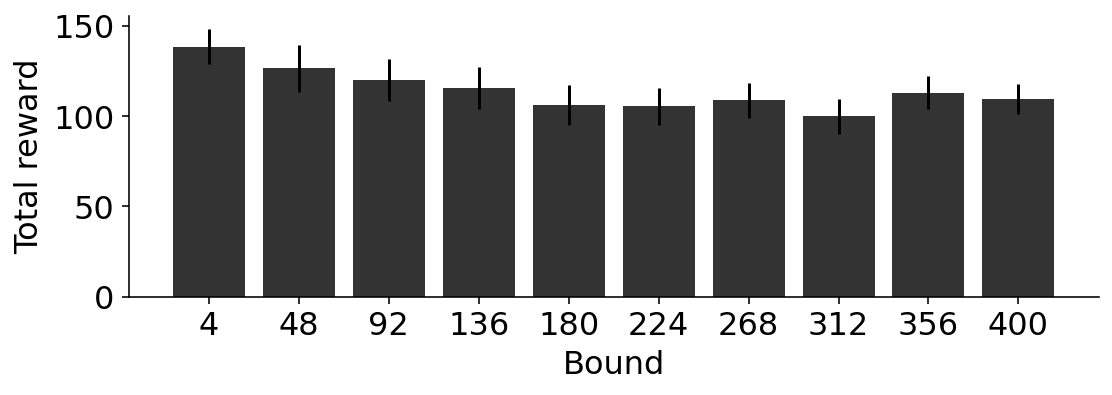

In [11]:
# CHANGE ME
start = 4 # min 4
stop = num_steps # max num_steps
num_search = 10 # ?

# -
# LEAVE ME
bounds = np.linspace(start, stop, num_search).astype(int)
names = [str(np.round(bound, 2)) for bound in bounds]

# !
results = []
for i, (name, bound) in enumerate(zip(names, bounds)):
    agent = BanditActorCritic(
        BoundedSequentialActor(num_actions=env.num_arms, bound=bound),
        CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
    )
    log = experiment(
        f"b_{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

# Score
scores = []
for name, res in zip(names, results):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s) in zip(names, scores):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot
fig = plt.figure(figsize=(8, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Bound")
plt.tight_layout()
sns.despine()

What parameter value did you you settle on for Agent 2?

I decided on a bound of 26. A bound of 4 returns the highest total reward, while 48 returns the second highest, so I just took the average of the two.

### Tuning Agent 3 for 4-armed bandit [5 pts]

In [ ]:
# Agent 3 = EpsilonActor/CriticUCB, tunable parameter = epsilon

In [12]:
num_steps = 4 * 100
epsilons = [0.05, 0.10, 0.25, 0.5, 0.75, 0.95]

names = [str(epsilon) for epsilon in epsilons]
colors = ["purple", "mediumpurple", "orchid", "mediumorchid", "violet", "mediumvioletred"]

In [13]:
# !
results = []
for i, (name, epsilon) in enumerate(zip(names, epsilons)):
    agent = BanditActorCritic(
        EpsilonActor(num_actions=env.num_arms, epsilon=epsilon),
        CriticUCB(num_inputs=env.num_arms, default_value=0.0)
    )
    log = experiment(
        f"ep_{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=100,
        dump=False,
        split_state=False,
    )
    results.append(log)

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

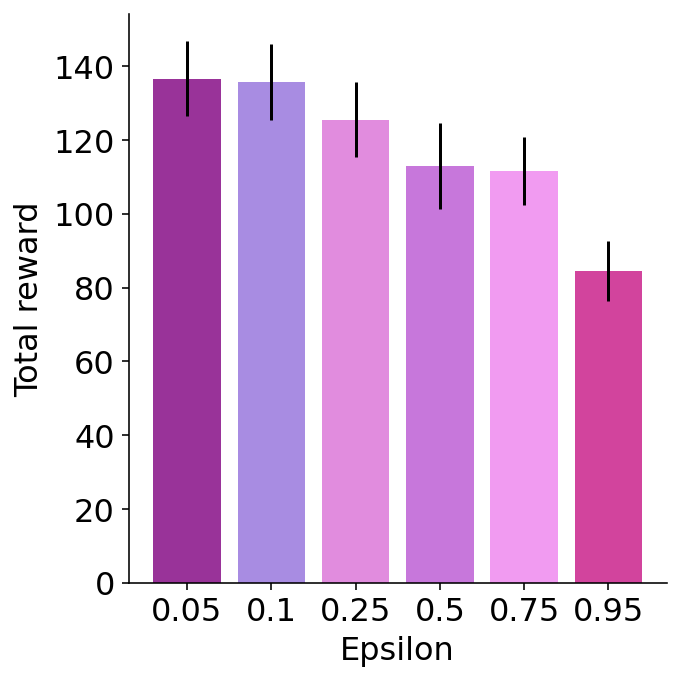

In [14]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 5))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Epsilon")
plt.tight_layout()
sns.despine()

What parameter value did you you settle on for Agent 3?

I decided on an epsilon of 0.075. A bound of 0.05 returns the highest total reward, while 0.1 returns the second highest, so I just took the average of the two.

### Creating a testing environment

In [7]:
bound = 26
epsilon = 0.075

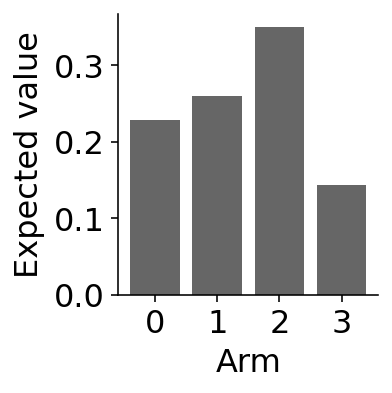

In [8]:
# don't touch
# Shared env params
seed = 15213
num_steps = 400

# Create env
env = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.35)
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

### Run 400 experiments and plot the average rewards for the 3 agents [5 pts]

In [9]:
bounded_ran = BanditActorCritic(
    BoundedRandomActor(num_actions=env.num_arms, bound=bound),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)
bounded_seq = BanditActorCritic(
    BoundedSequentialActor(num_actions=env.num_arms, bound=bound),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
epy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=epsilon),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [bounded_ran, bounded_seq, epy]
names = ["b-ran", "b-seq", "ep-greedy"]
colors = ["blue", "green", "purple"]

In [10]:
num_steps = 400
num_experiments = 400

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

b-ran:   0%|          | 0/400 [00:00<?, ?it/s]

b-seq:   0%|          | 0/400 [00:00<?, ?it/s]

ep-greedy:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

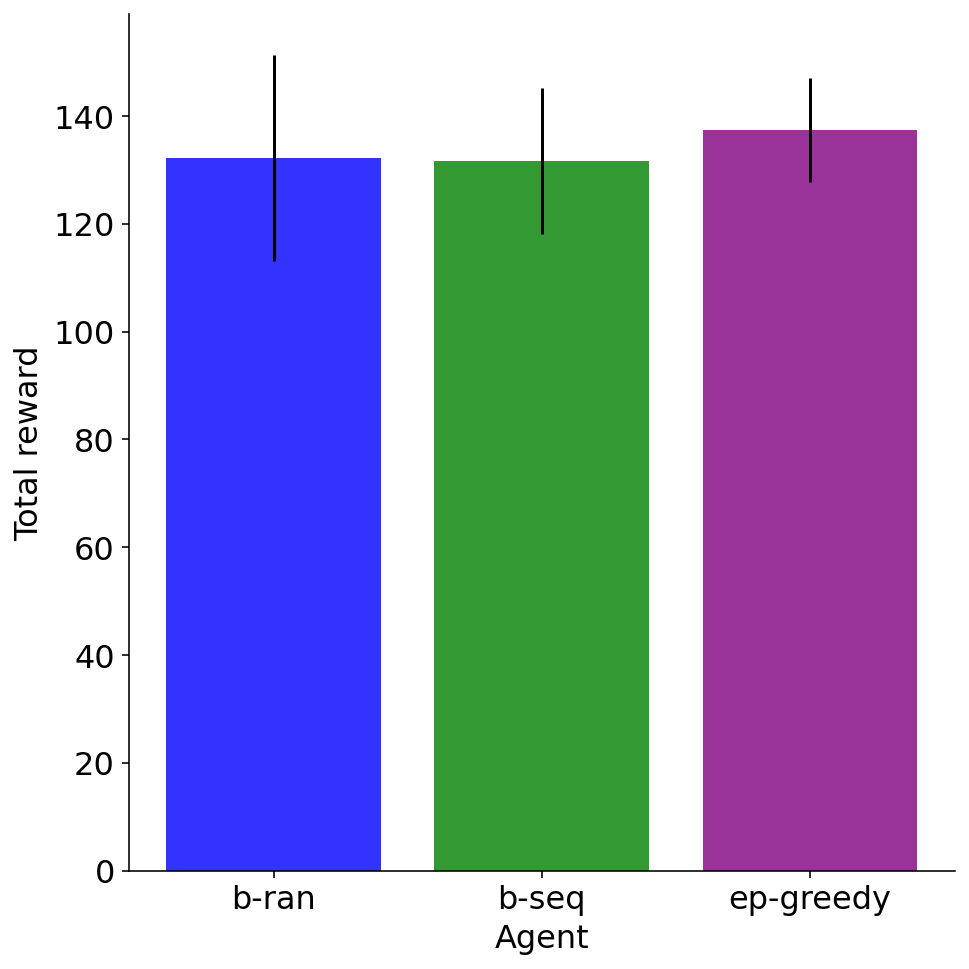

In [11]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(7, 7))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

### Question 3 [5 pts]

Did your results match what you predicted in Question 2? If not, do you have any ideas as to why?

The results match the predicted results. E-greedy/CriticUCB performed the best in terms of total reward acquired followed by BoundedRandom/CriticUCB followed by BoundedSequential/CriticNovelty (the latter two performed pretty much the same, but b-ran very slightly better though with greater variation, the difference is very miniscule).

## Section D - Deceptive bandits [50 pts total]

We will now consider the same types of agents placed into a different type of environment: the deceptive bandit.

### Creating the training environment

We are going to retune our agents, but we're not going to tune them against the deceptive bandit (or else it wouldn't be very deceptive, would it?).  Instead we are going to tune them against the non-deceptive 10-arm bandit from lab, which is identical to the deceptive bandit in terms of arm values but without the deception.

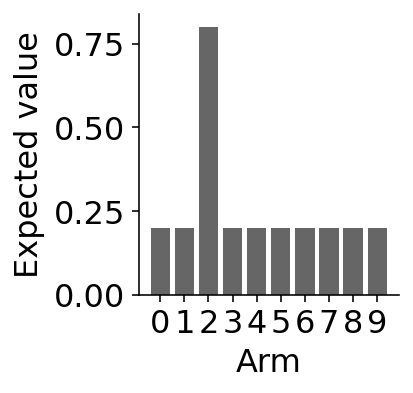

In [12]:
# don't touch
# Shared env params
seed = 503
num_steps = 400

# Create env
env = BanditUniform10(p_min=0.2, p_max=0.2, p_best=0.8)
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

### Question 4 [15 pts]

How well do you expect your agents to perform in the deceptive 10-arm environment, after being tuned in the non-deceptive environment?  Which one will score the highest and which one will score the lowest?

Similar to when you made a hypothesis in Section C, explain your answer fully.  Base it on your understanding of the properties of the actors and critics, as well as the results in lab. Consider the possible weaknesses of the agents, such as how certain parameter values might allow the agents to perform better in training but also cause the agents to be more easily deceived.

As in Section C, I predict that E-greedy/CriticUCB > BoundedRandom/CriticUCB > BoundedSequential/CriticNovelty. In Lab 5, we see that CriticUCB performs better than CriticNovelty in the deceptive 10-armed bandit unlike in the 4-armed bandit (120 vs. 80). This, in addition to E-greedy being a Q learning agent that learns from its environment vs. just explores, provides support for E-greedy/CriticUCB performing the best. I think BoundedRandom and BoundedSequential are also at greater disadvantages than E-greedy when they are tuned in a different environment from the test environment because their bound is specific to the non-deceptive environment. The same is true of e-greedy's epsilon but since it can learn and chooses its actions based on Q val rather than just exploring within a set bound, it is less impacted. I think that BoundedRandom and BoundedSequential will perform similiarly, though due to the results of HW4 discussed in Section C, I think that BoundedRandom will slightly outperform BoundedSequential.

### Tuning Agent 1 for 10-armed bandit [5 pts]

The process for tuning agents here should be roughly the same as in Section C.

In [ ]:
# BoundedRandomAgent / CriticUCB

In [21]:
num_steps = 4 * 100
num_experiments = 250

b_4:   0%|          | 0/250 [00:00<?, ?it/s]

b_48:   0%|          | 0/250 [00:00<?, ?it/s]

b_92:   0%|          | 0/250 [00:00<?, ?it/s]

b_136:   0%|          | 0/250 [00:00<?, ?it/s]

b_180:   0%|          | 0/250 [00:00<?, ?it/s]

b_224:   0%|          | 0/250 [00:00<?, ?it/s]

b_268:   0%|          | 0/250 [00:00<?, ?it/s]

b_312:   0%|          | 0/250 [00:00<?, ?it/s]

b_356:   0%|          | 0/250 [00:00<?, ?it/s]

b_400:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

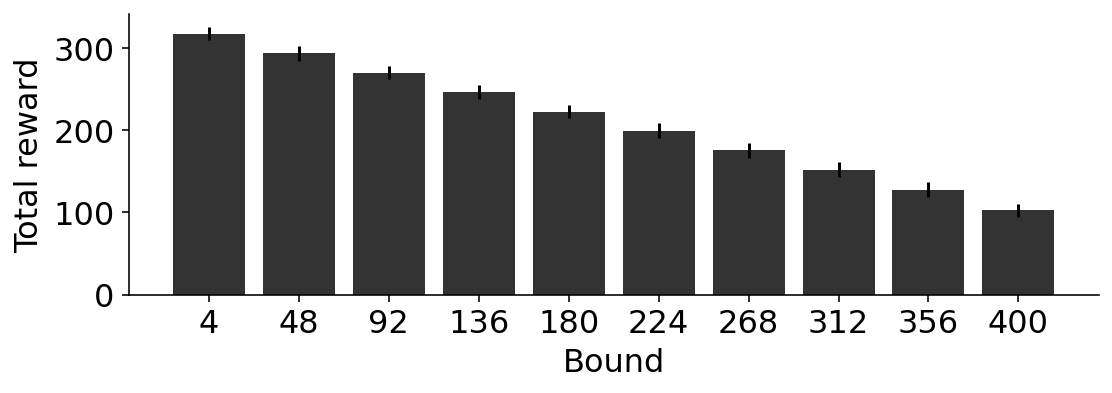

In [22]:
# CHANGE ME
start = 4 # min 4
stop = num_steps # max num_steps
num_search = 10 # ?

# -
# LEAVE ME
bounds = np.linspace(start, stop, num_search).astype(int)
names = [str(np.round(bound, 2)) for bound in bounds]

# !
results = []
for i, (name, bound) in enumerate(zip(names, bounds)):
    agent = BanditActorCritic(
        BoundedRandomActor(num_actions=env.num_arms, bound=bound),
        CriticUCB(num_inputs=env.num_arms, default_value=0.0)
    )
    log = experiment(
        f"b_{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

# Score
scores = []
for name, res in zip(names, results):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s) in zip(names, scores):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot
fig = plt.figure(figsize=(8, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Bound")
plt.tight_layout()
sns.despine()

What parameter value did you you settle on for Agent 1?

I decided on a bound of 26. A bound of 4 returns the highest total reward, while 48 returns the second highest, so I just took the average of the two.

### Tuning Agent 2 for 10-armed bandit [5 pts]

In [ ]:
# BoundedSequentialAgent / NoveltyCritic

b_4:   0%|          | 0/250 [00:00<?, ?it/s]

b_48:   0%|          | 0/250 [00:00<?, ?it/s]

b_92:   0%|          | 0/250 [00:00<?, ?it/s]

b_136:   0%|          | 0/250 [00:00<?, ?it/s]

b_180:   0%|          | 0/250 [00:00<?, ?it/s]

b_224:   0%|          | 0/250 [00:00<?, ?it/s]

b_268:   0%|          | 0/250 [00:00<?, ?it/s]

b_312:   0%|          | 0/250 [00:00<?, ?it/s]

b_356:   0%|          | 0/250 [00:00<?, ?it/s]

b_400:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

total_reward:   0%|          | 0/250 [00:00<?, ?it/s]

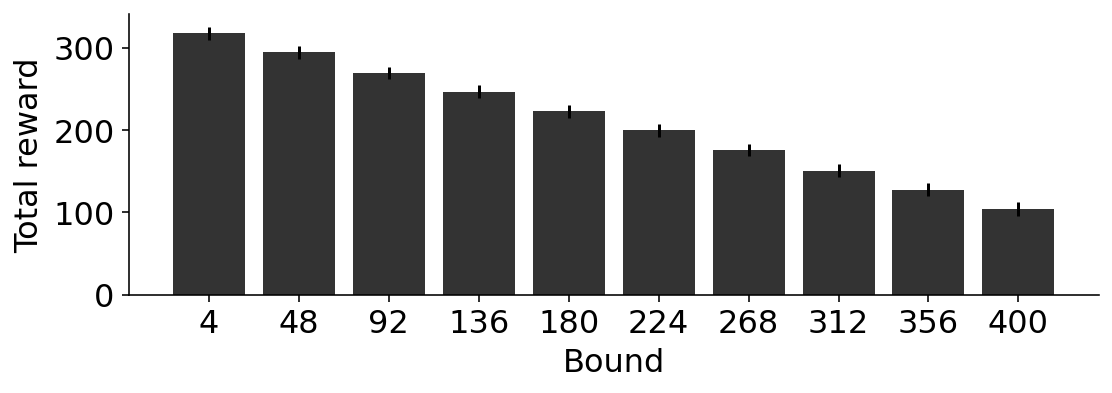

In [23]:
# CHANGE ME
start = 4 # min 4
stop = num_steps # max num_steps
num_search = 10 # ?

# -
# LEAVE ME
bounds = np.linspace(start, stop, num_search).astype(int)
names = [str(np.round(bound, 2)) for bound in bounds]

# !
results = []
for i, (name, bound) in enumerate(zip(names, bounds)):
    agent = BanditActorCritic(
        BoundedSequentialActor(num_actions=env.num_arms, bound=bound),
        CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
    )
    log = experiment(
        f"b_{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

# Score
scores = []
for name, res in zip(names, results):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s) in zip(names, scores):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot
fig = plt.figure(figsize=(8, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Bound")
plt.tight_layout()
sns.despine()

What parameter value did you you settle on for Agent 2?

I decided on a bound of 26. A bound of 4 returns the highest total reward, while 48 returns the second highest, so I just took the average of the two.

### Tuning Agent 3 for 10-armed bandit [5 pts]

In [ ]:
# EpsilonAgent / CriticUCB

In [24]:
num_steps = 4 * 100
epsilons = [0.05, 0.10, 0.25, 0.5, 0.75, 0.95]

names = [str(epsilon) for epsilon in epsilons]
colors = ["purple", "mediumpurple", "orchid", "mediumorchid", "violet", "mediumvioletred"]

In [25]:
# !
results = []
for i, (name, epsilon) in enumerate(zip(names, epsilons)):
    agent = BanditActorCritic(
        EpsilonActor(num_actions=env.num_arms, epsilon=epsilon),
        CriticUCB(num_inputs=env.num_arms, default_value=0.0)
    )
    log = experiment(
        f"ep_{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=100,
        dump=False,
        split_state=False,
    )
    results.append(log)

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

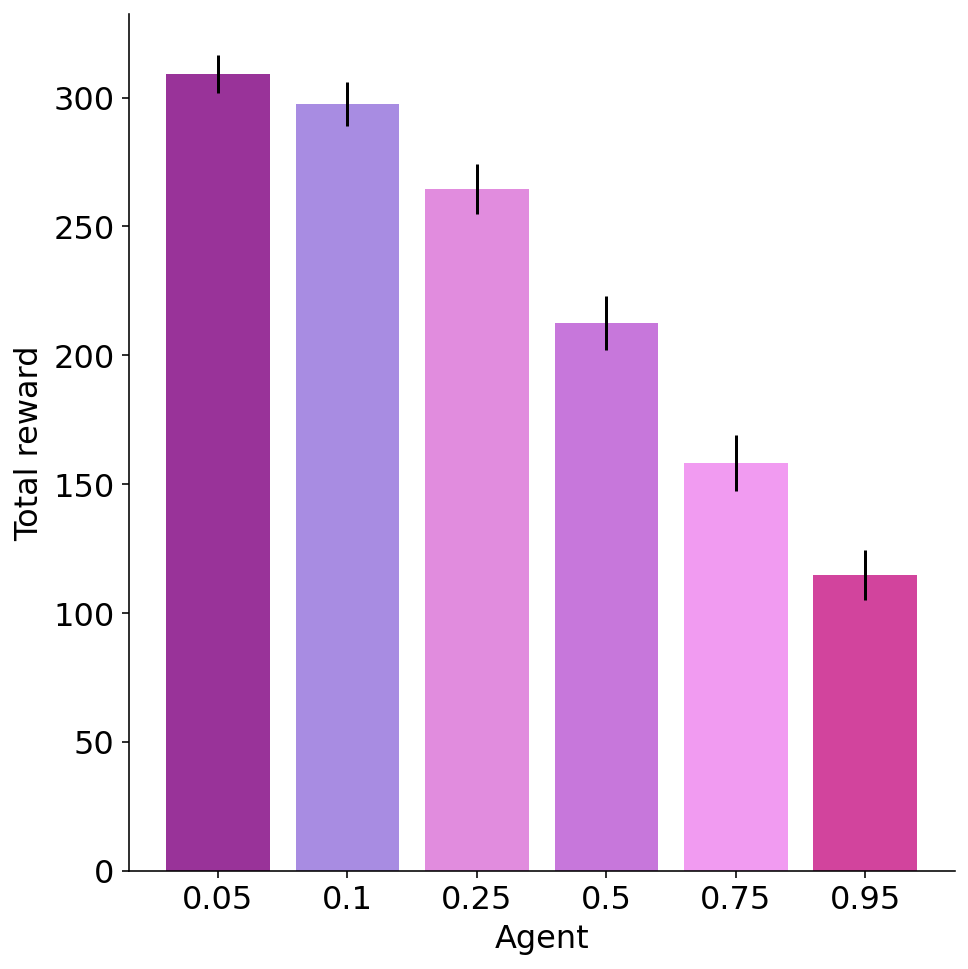

In [26]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(7, 7))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

What parameter value did you you settle on for Agent 3?

I decided on an epsilon of 0.075. An epsilon of 0.05 returns the highest total reward, while 0.1 returns the second highest, so I just took the average of the two.

### Creating a testing (deceptive) environment

In [13]:
bound = 26
epsilon = 0.075

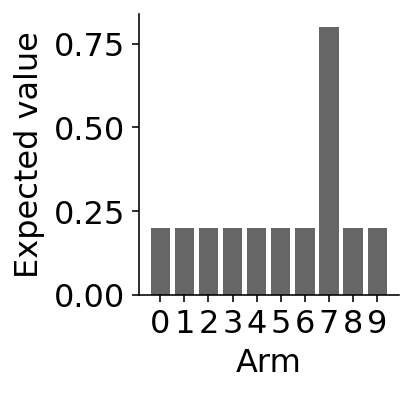

In [14]:
# don't touch
# Shared env params
seed = 15213
num_steps = 400

# Create env
env = DeceptiveBanditOneHigh10()
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

### Run 400 experiments and plot the average rewards for the 3 agents [5 pts]

In [15]:
bounded_ran = BanditActorCritic(
    BoundedRandomActor(num_actions=env.num_arms, bound=bound),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)
bounded_seq = BanditActorCritic(
    BoundedSequentialActor(num_actions=env.num_arms, bound=bound),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
epy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=epsilon),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [bounded_ran, bounded_seq, epy]
names = ["b-ran", "b-seq", "ep-greedy"]
colors = ["blue", "green", "purple"]

In [16]:
num_steps = 400
num_experiments = 400

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

b-ran:   0%|          | 0/400 [00:00<?, ?it/s]

b-seq:   0%|          | 0/400 [00:00<?, ?it/s]

ep-greedy:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

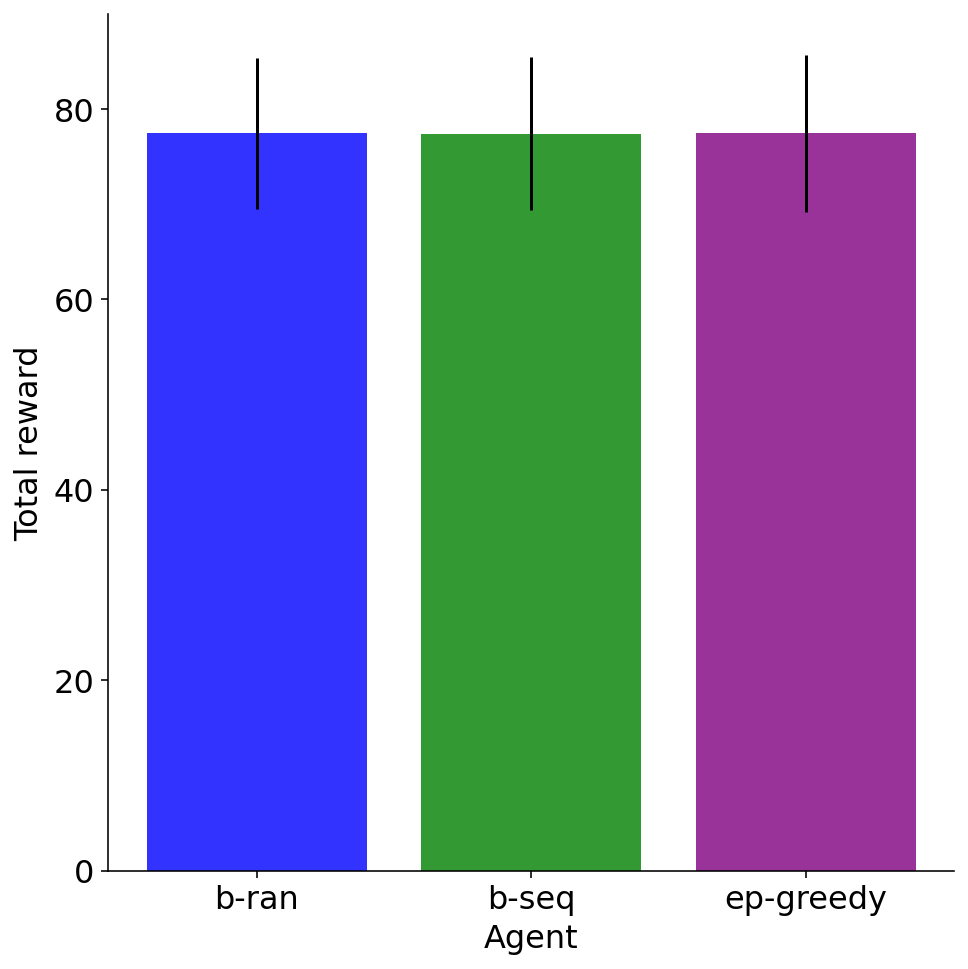

In [17]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(7, 7))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

### Question 5 [5 pts]

Did your results match what you predicted in Question 4? If not, do you have any ideas as to why?

We don't really see a clear winner in this case -- the results show all three agents performed basically the same in this environment unlike predictions. Since epsilon of egreedy is very close to 0, it may have struggled with adapting to the decreasing value of the optimal arm (since it would exploit more rather than explore). However, since it performs better than the other 2 when the environment is non-deceptive, it still managed to perform similarly to the other two. The other two agents are both exploratory agents with the same bound so it makes sense that they performed similiarly.

### Question 6 [10 pts]

Time for some conclusions. Was there a clear winner among your three selected agents?  Was there one which performed the best against both non-deceptive and deceptive bandits?  Or did different agents perform better or worse in different scenarios?  Which agent would you pick as your favorite?

There was a clear winner among my three selected agents in the non-deceptive but not deceptive bandit: E-greedy/CriticUCB in former, all performed similiarly in latter. Still, I would pick E-greedy/CriticUCB as my favorite since it does perform better in the non-deceptive bandit and it is learning from the environment rather than just exploring at random or in a sequential fashion (more suitable to adapting to env). 

## Submission

**DUE:** 5pm EST, Nov 30, 2021. Email the link to the completed notebook on your Github repository to the TA and me via Canvas.

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> n/a